In [1]:
import numpy as np

import os, imp

import matplotlib.pyplot as plt

from PIL import Image

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14,10)

%matplotlib inline

In [2]:
# Get the path to the lego directory
_package_path = '/home/sean/Insight/legos/'

# Load the image processing library
_ip_subpkg = 'image_processing'
_ip_module = 'image_processing.py'
ip         = imp.load_source(_ip_subpkg, _package_path+_ip_subpkg+'/'+_ip_module)

In [3]:
lego_dir = '/home/sean/Desktop/lego_images_bounding_raw/'

lego_file_list = os.listdir( lego_dir )

In [10]:
n_images = 3

min_false_image_mult = 4
max_false_image_mult = 10

min_false_image_resize = 0.9
max_false_image_resize = 1.5

min_solo_image_mult = 1.6
max_solo_image_mult = 2.0

rand_noise_avg_min = 100
rand_noise_avg_max = 200

rand_noise_std_min = 10
rand_noise_std_max = 50

min_n_images = 1
max_n_images = 4

In [5]:
import random
import numpy     as np
import PIL.Image as Image
import matplotlib.patches as patches

def get_avg_background_color( inp_arr ):
    return ( 
                inp_arr[  0 ,  0 ] +  
                inp_arr[  0 , -1 ] +  
                inp_arr[ -1 ,  0 ] +  
                inp_arr[ -1 , -1 ] 
           ) / 4.

def get_pil_img_arr( img ):
    image_arr = np.array( img.getdata() )
    r_vals = image_arr[:,0].reshape( img.size[::-1] )
    g_vals = image_arr[:,1].reshape( img.size[::-1] )
    b_vals = image_arr[:,2].reshape( img.size[::-1] )
    return np.array( [r_vals,g_vals,b_vals] )

big_counter = 0
out_img_counter = 0
out_box_list = {}

Below here, begin creating false images

In [6]:
lego_file_name = lego_dir + lego_file_list[0]

lego_image_base = Image.open( lego_file_name )

Now, need to get background color

In [7]:
lego_image_base_arr = get_pil_img_arr( lego_image_base )

r_vals = lego_image_base_arr[0]
g_vals = lego_image_base_arr[1]
b_vals = lego_image_base_arr[2]


image_rgb_arr = np.array( [ r_vals, g_vals, b_vals ] )

In [8]:
background_images = os.listdir( '/home/sean/Pictures/Me' )

All need:
    Rotation
    Translation
    Noise

Options:
    Minor rescaling, 1 lego
    Single lego in image
    Other legos in image

Minor rescaling

In [29]:
def generate_rescaled_image( 
                                inp_img          ,
                                embed_resize_min , 
                                embed_resize_max , 
                                outer_mult_min   , 
                                outer_mult_max   ,
                                ret_bounds=False ,
                           ):
    
    # np array
    inp_arr = get_pil_img_arr( inp_img )
    
    # Whether or not we will flip the image
    rand_flip = random.randint( 0, 1 )
    
    # Rotation, 0 0deg, 1 90deg, 2 180deg, 3 270deg
    rand_rot  = random.randint( 0, 3 )
    
    # Get amount we will resize embedded image by
    rand_resize = random.uniform( 
                                    embed_resize_min , 
                                    embed_resize_max , 
                                )
    
    # Generate random size of outer image, will flip if rand_flip==1
    rand_size = random.uniform( 
                                outer_mult_min , 
                                outer_mult_max , 
                              ) * np.array( inp_arr.shape[1:3] )

    
    # Resized to 
    resize_size = rand_resize * np.array( inp_arr.shape[1:3] )
    resize_size = [ int( resize_size[0] ) , int( resize_size[1]) ]
    
    
    # Copy original image, but resize it for variation
    inset_img = inp_img.resize( resize_size, Image.ANTIALIAS )    
    inset_arr = inp_arr
    
    
    # Flip the image across h axis
    if ( rand_flip ):
        new_arr = inset_arr.copy()
        for i in range( 0 , 3 ):
            new_arr[i,:,:] = ip.h_flip_array( inset_arr[i] )
        inset_arr = new_arr.copy()
    
    # Rotate the image
    if ( rand_rot != 0 ):
        new_arr = inset_arr.copy()
        for i in range( 0 , 3 ):
                new_arr[i,:,:] = np.rot90( inset_arr[i], rand_rot )
        inset_arr = new_arr.copy()
    
    # 90 or 270 need to flip rand_size as well
    if ( rand_rot % 2 == 1 ):
        rand_size = rand_size[::-1]
    
    # Generate the false image, set as full white
    false_image = np.ones( [3,int(rand_size[0]),int(rand_size[1])], dtype=int )    
    for i in range( 0 , 3 ):
        false_image[i] = false_image[i] * 255#avg_background_color[i]

    
    # Get new coordinates
    min_x = random.randint( 0, false_image.shape[1]-inset_arr.shape[1] - 2 )
    max_x = min_x + inset_arr.shape[1]
    min_y = random.randint( 0, false_image.shape[2]-inset_arr.shape[2] - 2 )
    max_y = min_y + inset_arr.shape[2]

    
    # Embed image
    for i in range( 0, 3 ):
        false_image[
                    i,
                    min_x:max_x,
                    min_y:max_y
                   ] = inset_arr[i]

    # Replace white with red... (leaves alpha values alone...)
    white_areas = (false_image[0] == 255) & (false_image[0] == 255) & (false_image[0] == 255)
    
    # Generate noise
    for rgb in range( 0, 3 ):
        noise_avg = random.uniform( 
                                    rand_noise_avg_min , 
                                    rand_noise_avg_max , 
                                  )
        noise_std = random.uniform( 
                                    rand_noise_avg_min , 
                                    rand_noise_avg_max , 
                                  )

        noise_arr = ( (
                        noise_std*np.random.randn( 
                                                    false_image[rgb].shape[0], 
                                                    false_image[rgb].shape[1] 
                                                  )+noise_avg
                      ).astype(int) 
                    )
    
        noise_arr[ noise_arr > 255 ] = 255
        noise_arr[ noise_arr <   0 ] =   0
        false_image[rgb][white_areas] = noise_arr[white_areas].copy()

    if (ret_bounds):
        return false_image, {'x_min':min_x,'x_max':max_x,'y_min':min_y,'y_max':max_y}
    return false_image

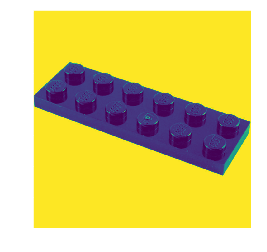

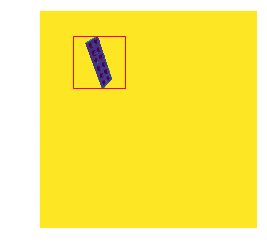

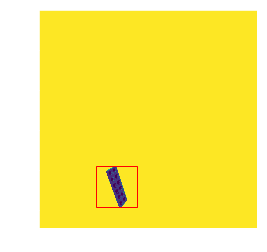

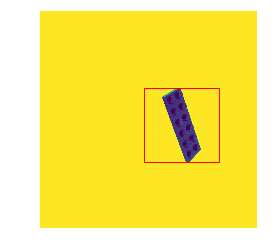

In [38]:
plt.imshow( image_rgb_arr[0] )
plt.show()



# Loop over number of reproduced images we will make
for false_image_i in range( 0 , n_images ):

    lego_arr = toss_lego( 
                            lego_image_base,
                            min_false_image_resize,
                            max_false_image_resize,
                         )
    
    img_arr, bound_dict = embed_lego(
                                lego_arr ,
                                min_false_image_mult   ,
                                max_false_image_mult   ,
                           )
    
    min_x = bound_dict['x_min'] 
    max_x = bound_dict['x_max']
    min_y = bound_dict['y_min'] 
    max_y = bound_dict['y_max']
    
    fig, ax = plt.subplots(1)
    rect = patches.Rectangle((min_y,min_x),max_x-min_x,max_y-min_y,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

    
    out_box_list[str(big_counter)] = [min_x,min_y,max_x,max_y]
    


    big_counter = big_counter + 1
    

    ax.imshow( img_arr[0] )
    plt.show()

Add multiple images

Generate main image stuff

Then select out non-white pixels

In [100]:
def embed_lego(
                lego_image_arr,
                min_false_image_mult,
                max_false_image_mult,
              ):
    
    # Generate random size of outer image, will flip if rand_flip==1
    rand_size = random.uniform( 
                                min_false_image_mult , 
                                max_false_image_mult , 
                              ) * np.array( lego_image_arr.shape[1:3] )
    
    # Generate the false image, set as full white
    false_image = np.ones( [3,int(rand_size[0]),int(rand_size[1])], dtype=int )    
    for i in range( 0 , 3 ):
        false_image[i] = false_image[i] * 255#avg_background_color[i]

    
    # Get new coordinates
    min_x = random.randint( 0, false_image.shape[1]-inset_arr.shape[1] - 2 )
    max_x = min_x + inset_arr.shape[1]
    min_y = random.randint( 0, false_image.shape[2]-inset_arr.shape[2] - 2 )
    max_y = min_y + inset_arr.shape[2]
    
    # Embed image
    for i in range( 0, 3 ):
        false_image[
                    i,
                    min_x:max_x,
                    min_y:max_y
                   ] = inset_arr[i]
    # Replace white with red... (leaves alpha values alone...)
    white_areas = (false_image[0] == 255) & (false_image[0] == 255) & (false_image[0] == 255)
    
    # Generate noise
    for rgb in range( 0, 3 ):
        noise_avg = random.uniform( 
                                    rand_noise_avg_min , 
                                    rand_noise_avg_max , 
                                  )
        noise_std = random.uniform( 
                                    rand_noise_avg_min , 
                                    rand_noise_avg_max , 
                                  )

        noise_arr = ( (
                        noise_std*np.random.randn( 
                                                    false_image[rgb].shape[0], 
                                                    false_image[rgb].shape[1] 
                                                  )+noise_avg
                      ).astype(int) 
                    )
    
        noise_arr[ noise_arr > 255 ] = 255
        noise_arr[ noise_arr <   0 ] =   0
        false_image[rgb][white_areas] = noise_arr[white_areas].copy()

        
    return false_image, {'x_min':min_x,'x_max':max_x,'y_min':min_y,'y_max':max_y}
    
    
def toss_lego (
                inp_img ,
                min_false_image_resize ,
                max_false_image_resize ,
              ):
    
    # np array
    inp_arr = get_pil_img_arr( inp_img )
    
    # Whether or not we will flip the image
    rand_flip = random.randint( 0, 1 )
    
    # Rotation, 0 0deg, 1 90deg, 2 180deg, 3 270deg
    rand_rot  = random.randint( 0, 3 )
    
    # Get amount we will resize embedded image by
    rand_resize = random.uniform( 
                                    min_false_image_resize , 
                                    max_false_image_resize , 
                                )
    
    # Resized to 
    resize_size = rand_resize * np.array( inp_arr.shape[1:3] )
    resize_size = [ int( resize_size[0] ) , int( resize_size[1]) ]
    
    
    # Copy original image, but resize it for variation
    inset_img = inp_img.resize( resize_size, Image.ANTIALIAS )    
    inset_arr = inp_arr
    
    
    # Flip the image across h axis
    if ( rand_flip ):
        new_arr = inset_arr.copy()
        for i in range( 0 , 3 ):
            new_arr[i,:,:] = ip.h_flip_array( inset_arr[i] )
        inset_arr = new_arr.copy()
    
    # Rotate the image
    if ( rand_rot != 0 ):
        new_arr = inset_arr.copy()
        for i in range( 0 , 3 ):
                new_arr[i,:,:] = np.rot90( inset_arr[i], rand_rot )
        inset_arr = new_arr.copy()
    
    return inset_arr


def embed_another_lego(
                        lego_img,
                        outer_img_arr,
                        min_false_image_resize ,
                        max_false_image_resize ,
                      ):
    
    # Move the lego around
    lego_arr = toss_lego( 
                        lego_img,
                        min_false_image_resize,
                        max_false_image_resize,
                     )
    

    # Actually, non white areas
    white_areas = ( (lego_arr[0] != 255) & (lego_arr[1] != 255) & (lego_arr[2] != 255) )

    # Get new coordinates
    min_x = random.randint( 0, outer_img_arr.shape[1]-lego_arr.shape[1] - 2 )
    max_x = min_x + lego_arr.shape[1]
    min_y = random.randint( 0, outer_img_arr.shape[2]-lego_arr.shape[2] - 2 )
    max_y = min_y + lego_arr.shape[2]
    
    # Embed image
    for i in range( 0, 3 ):
        embed_slice = outer_img_arr[
                        i,
                       min_x:max_x,
                        min_y:max_y
                     ]
        embed_slice[white_areas] = lego_arr[i][white_areas]
        outer_img_arr[
                        i,
                        min_x:max_x,
                        min_y:max_y
                     ] = embed_slice

    return outer_img_arr, {'x_min':min_x,'x_max':max_x,'y_min':min_y,'y_max':max_y}


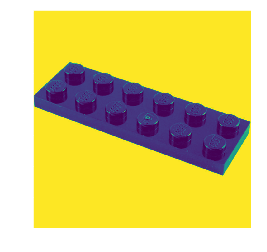

img_arr shape (3, 6605, 6605)
{'x_min': 2891, 'y_max': 2009, 'y_min': 1309, 'x_max': 3591}


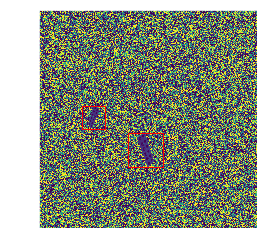

img_arr shape (3, 4828, 4828)
{'x_min': 1331, 'y_max': 4534, 'y_min': 3834, 'x_max': 2031}


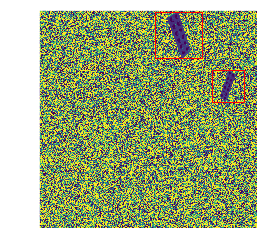

img_arr shape (3, 5127, 5127)
{'x_min': 1919, 'y_max': 5120, 'y_min': 4420, 'x_max': 2619}


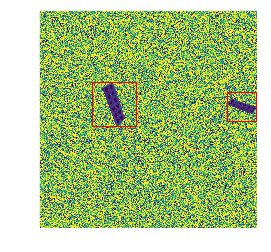

In [101]:
plt.imshow( image_rgb_arr[0] )
plt.show()

n_images = 3
n_add_img = 1

# Loop over number of reproduced images we will make
for false_image_i in range( 0 , n_images ):
    fig, ax = plt.subplots(1)

    lego_arr = toss_lego( 
                            lego_image_base,
                            min_false_image_resize,
                            max_false_image_resize,
                         )
    
    img_arr, bound_dict = embed_lego(
                                lego_arr ,
                                min_false_image_mult   ,
                                max_false_image_mult   ,
                           )
    
    min_x = bound_dict['x_min'] 
    max_x = bound_dict['x_max']
    min_y = bound_dict['y_min'] 
    max_y = bound_dict['y_max']
    
    orig_rect = patches.Rectangle((min_y,min_x),max_x-min_x,max_y-min_y,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes

    
    out_box_list[str(big_counter)] = [min_x,min_y,max_x,max_y]
    
    bound_list = []
    for add_img in range( 0, n_add_img ):
        img_arr, bound_b = embed_another_lego( 
                                                lego_image_base,
                                                img_arr,
                                                min_false_image_resize,
                                                max_false_image_resize,
                                              )
        ax.imshow( img_arr[0] )
    
        print bound_b
        min_x = bound_b['x_min'] 
        max_x = bound_b['x_max']
        min_y = bound_b['y_min'] 
        max_y = bound_b['y_max']
        out_box_list[str(big_counter)+'_'+str(add_img)] = [min_x,min_y,max_x,max_y]

        rect = patches.Rectangle((min_y,min_x),max_x-min_x,max_y-min_y,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    ax.add_patch(orig_rect)

    big_counter = big_counter + 1
    

    plt.show()

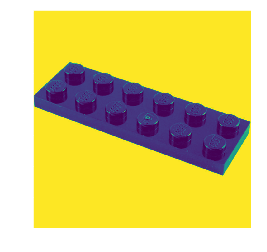

ValueError: shape mismatch: value array of shape (1124,1124) could not be broadcast to indexing result of shape (936257,)

In [50]:
plt.imshow( image_rgb_arr[0] )
plt.show()


# Loop over number of reproduced images we will make
for false_image_i in range( 0 , n_images ):

# For 1/single    
    # Number of additional images to use
    n_img_use = random.randint( 1, 2 )
    
    # Get the random images
    additional_img_arr = []
    for add_i in range( 0, n_img_use ):
        try:
            rand_index = random.randint( 0, len(lego_file_list) )
            rand_img = Image.open( lego_dir + lego_file_list[rand_index] )
            additional_img_arr.append( get_pil_img_arr(rand_img) )
        except:
            pass
#

# Modify based on image grouping
    # Generate random size of new image, will flip if rand_flip==1
    rand_size = random.randint( 
                                min_false_image_mult , 
                                max_false_image_mult 
                              ) * np.array( r_vals.shape )
#

    # Whether or not we will flip the image
    rand_flip = random.randint( 0, 1 )
    
    # Rotation, 0 0deg, 1 90deg, 2 180deg, 3 270deg
    rand_rot  = random.randint( 0, 3 )
    
    
    # Get amount we will resize by
    rand_resize = random.uniform( 
                                    min_false_image_resize , 
                                    max_false_image_resize , 
                                )
    
    
    # Resized 
    resize_size = rand_resize * np.array( lego_image_base.size )
    resize_size = [ int( resize_size[0] ) , int( resize_size[1]) ]
    
    
    
    
    # Copy original image, but resize it for variation
    inset_img = lego_image_base.resize( resize_size, Image.ANTIALIAS )    
    inset_arr = get_pil_img_arr( inset_img )
    
    # Flip the image across h axis
    if ( rand_flip ):
        new_arr = inset_arr.copy()
        
        for i in range( 0 , 3 ):
            new_arr[i,:,:] = ip.h_flip_array( inset_arr[i] )
        inset_arr = new_arr.copy()
    
    
    # Rotate the image
    new_arr = inset_arr.copy()
    for i in range( 0 , 3 ):
            new_arr[i,:,:] = np.rot90( inset_arr[i], rand_rot )
    inset_arr = new_arr.copy()
    
    # 90 or 270 need to flip rand_size as well
    if ( rand_rot % 2 == 1 ):
        rand_size = rand_size[::-1]
    
    
    
    rand_background = random.randint( 0, len( background_images )-1 )
    rand_rot        = random.randint( 0, 360 )
    rand_back_image = Image.open('/home/sean/Pictures/Me/'+background_images[rand_background])
    rand_back_image = rand_back_image.resize( [false_image.shape[1],false_image.shape[2]], Image.ANTIALIAS )
    rand_back_image = rand_back_image.rotate( rand_rot )
    dirty_background= get_pil_img_arr( rand_back_image )
#    back_inds       = (
#                        ( false_image[0,:,:] == 255 ) & 
#                        ( false_image[1,:,:] == 255 ) &
#                        ( false_image[2,:,:] == 255 ) 
#    )
    
#    for i in range( 0, 3 ):
#        false_image[i,back_inds] = dirty_backround[i,back_inds]
    false_image = dirty_background
    
    # Generate the false image
#    false_image = np.ones( [3,rand_size[0],rand_size[1]], dtype=int )    
#    for i in range( 0 , 3 ):
#        false_image[i] = false_image[i] * avg_background_color[i]

    
    # Get new coordinates
    min_x = random.randint( 0, false_image.shape[1]-inset_arr.shape[1] - 2 )
    max_x = min_x + inset_arr.shape[1]
    min_y = random.randint( 0, false_image.shape[2]-inset_arr.shape[2] - 2 )
    max_y = min_y + inset_arr.shape[2]

    my_mask = (
                ( inset_arr[0,:,:] == 255 )&
                ( inset_arr[1,:,:] == 255 )&
                ( inset_arr[2,:,:] == 255 )
    )
    
    for i in range( 0, 3 ):
        
        inset_arr[i,my_mask] = false_image[i,                    min_x:max_x,
                    min_y:max_y
]
        
        false_image[
                    i,
                    min_x:max_x,
                    min_y:max_y
                   ] = inset_arr[i]

    
        
    fig, ax = plt.subplots(1)
    rect = patches.Rectangle((min_y,min_x),max_x-min_x,max_y-min_y,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

    
    out_box_list[str(big_counter)] = [min_x,min_y,max_x,max_y]
    
#
    n_add_img = len( additional_img_arr )
    for n_additional in range( 0, n_add_img):
        # Get new coordinates
        min_x = random.randint( 0, false_image.shape[1]-additional_img_arr[n_additional].shape[1] - 2 )
        max_x = min_x + additional_img_arr[n_additional].shape[1]
        min_y = random.randint( 0, false_image.shape[2]-additional_img_arr[n_additional].shape[2] - 2 )
        max_y = min_y + additional_img_arr[n_additional].shape[2]            
        
        for i in range( 0, 3 ):
            false_image[
                        i,
                        min_x:max_x,
                        min_y:max_y
                       ] = additional_img_arr[n_additional][i]
        out_box_list[str(big_counter)+'_'+str(n_additional)] = [min_x,min_y,max_x,max_y]

        rect = patches.Rectangle((min_y,min_x),max_x-min_x,max_y-min_y,linewidth=1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)


#
#    for     ind_0 in range( 0, false_image.shape[1] ):
#        for ind_1 in range( 0, false_image.shape[2] ):
#            if ( 
#                    ( false_image[0,ind_0,ind_1] == 255 ) & 
#                    ( false_image[1,ind_0,ind_1] == 255 ) &
#                    ( false_image[2,ind_0,ind_1] == 255 ) 
#               ):
#                false_image[ 0, ind_0, ind_1 ] = dirty_backround[ 0, ind_0, ind_1 ]
#                false_image[ 1, ind_0, ind_1 ] = dirty_backround[ 1, ind_0, ind_1 ]
#                false_image[ 2, ind_0, ind_1 ] = dirty_backround[ 2, ind_0, ind_1 ]
#
        
#


#    rect = patches.Rectangle((min_y,min_x),max_x-min_x,max_y-min_y,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
#    ax.add_patch(rect)


    big_counter = big_counter + 1
    

    ax.imshow( false_image[0] )
    print rand_flip, rand_rot
    plt.show()
#    print false_image.shape[1]-inset_arr.shape[1] - 2
#    print false_image.shape[2]-inset_arr.shape[2] - 2
#    print false_image.shape, inset_arr.shape
#    print min_x, max_x
#    print min_y, max_y
#    print false_image[i]
    
    # Resize
    
#    print rand_flip
#    print rand_rot
#    plt.imshow( image_rgb_arr[0] )
#    plt.show()
#    plt.imshow( new_arr[0] )
#    plt.show()

# need embed

In [138]:
false_image

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]])

In [154]:
bar = np.swapaxes( false_image, 0, 2 )##np.zeros( [false_image.shape[2],false_image.shape[1],false_image.shape[0]] )
#for         i in range( 0 , false_image.shape[2] ):
#    for     j in range( 0 , false_image.shape[1] ):
#        for k in range ( 0 , false_image.shape[0] ):
#            bar[i,j,k] = false_image[k,j,i]

foo = Image.fromarray( bar.astype('uint8'), 'RGB' )

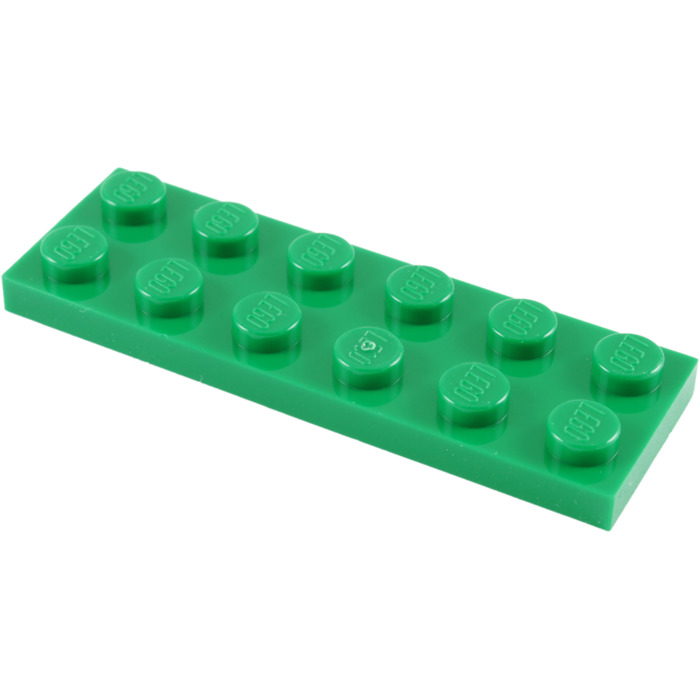

In [157]:
lego_image_base

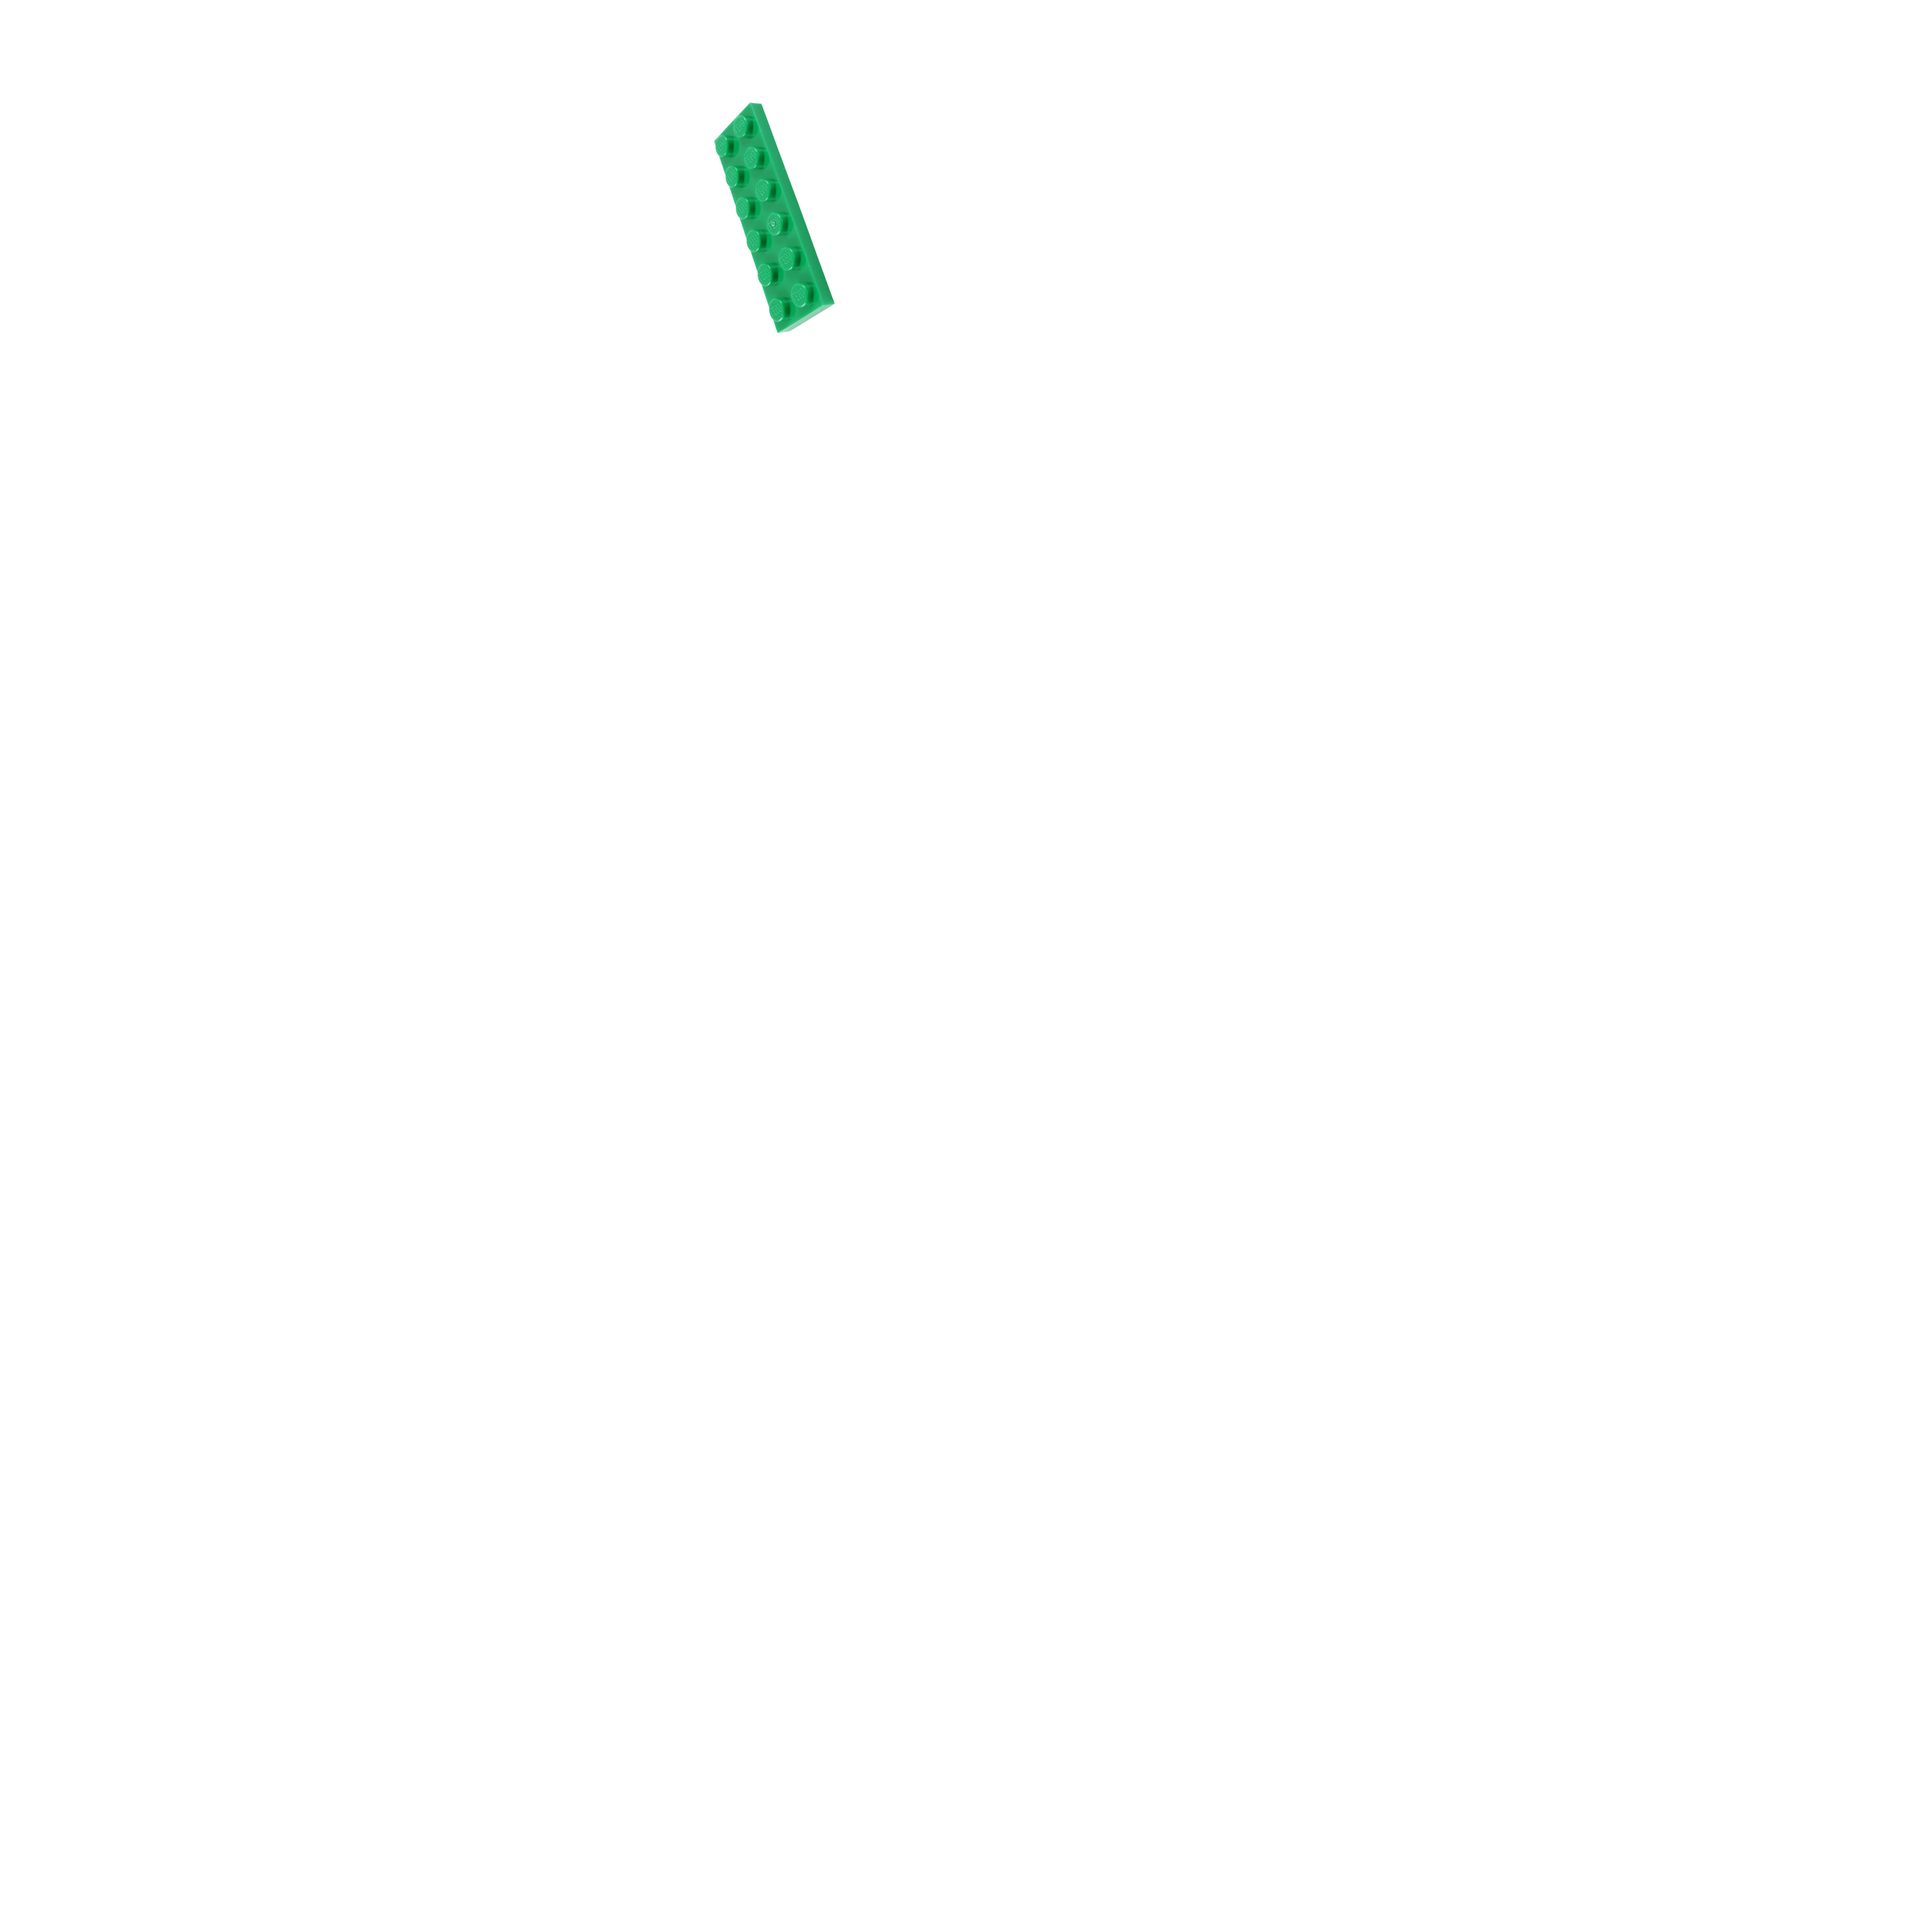

In [155]:
foo

In [1]:
import random
import numpy     as np
import PIL.Image as Image
import matplotlib.patches as patches
import numpy as np

import os, imp

import matplotlib.pyplot as plt

from PIL import Image

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14,10)

%matplotlib inline


# Get the path to the lego directory
_package_path = '/home/sean/Insight/legos/'

# Load the image processing library
_ip_subpkg = 'image_processing'
_ip_module = 'image_processing.py'
ip         = imp.load_source(_ip_subpkg, _package_path+_ip_subpkg+'/'+_ip_module)


lego_dir = '/home/sean/Desktop/lego_images_bounding_raw/'
background_images = os.listdir( '/home/sean/Pictures/Me' )

lego_file_list = os.listdir( lego_dir )


# CHANGE THESE
n_images = 5

min_false_image_mult = 4
max_false_image_mult = 6

min_false_image_resize = 0.25
max_false_image_resize = 2.0

out_dir = '/home/sean/Desktop/lego_images_bounding_box_dirty/'



def get_avg_background_color( inp_arr ):
    return ( 
                inp_arr[  0 ,  0 ] +  
                inp_arr[  0 , -1 ] +  
                inp_arr[ -1 ,  0 ] +  
                inp_arr[ -1 , -1 ] 
           ) / 4.

def get_pil_img_arr( img ):
    image_arr = np.array( img.getdata() )
    r_vals = image_arr[:,0].reshape( img.size[::-1] )
    g_vals = image_arr[:,1].reshape( img.size[::-1] )
    b_vals = image_arr[:,2].reshape( img.size[::-1] )
    return np.array( [r_vals,g_vals,b_vals] )

out_img_counter = 0
out_box_list = {}
big_counter  = 0

for lego_file in lego_file_list:
    try:
        lego_file_name = lego_dir + lego_file
        lego_image_base = Image.open( lego_file_name )

        lego_image_base_arr = get_pil_img_arr( lego_image_base )

        r_vals = lego_image_base_arr[0]
        g_vals = lego_image_base_arr[1]
        b_vals = lego_image_base_arr[2]

        avg_background_r = get_avg_background_color( r_vals )
        avg_background_g = get_avg_background_color( g_vals )
        avg_background_b = get_avg_background_color( b_vals )

        avg_background_color = [
                                   int( avg_background_r ),
                                   int( avg_background_g ),
                                   int( avg_background_b ),
                               ]

        image_rgb_arr = np.array( [ r_vals, g_vals, b_vals ] )

        # Loop over number of reproduced images we will make
        for false_image_i in range( 0 , n_images ):

    
            # Number of additional images to use
            n_img_use = random.randint( 1, 2 )

            # Get the random images
            additional_img_arr = []
            for add_i in range( 0, n_img_use ):
                try:
                    rand_index = random.randint( 0, len(lego_file_list) )
                    rand_img = Image.open( lego_dir + lego_file_list[rand_index] )
                    additional_img_arr.append( get_pil_img_arr(rand_img) )
                except:
                    pass


            
            # Whether or not we will flip the image
            rand_flip = random.randint( 0, 1 )

            # Rotation, 0 0deg, 1 90deg, 2 180deg, 3 270deg
            rand_rot  = random.randint( 0, 3 )

            # Generate random size of new image, will flip if rand_flip==1
            rand_size = random.randint( 
                                        min_false_image_mult , 
                                        max_false_image_mult 
                                      ) * np.array( r_vals.shape )

            # Get amount we will resize by
            rand_resize = random.uniform( 
                                            min_false_image_resize , 
                                            max_false_image_resize , 
                                        )


            # Resized 
            resize_size = rand_resize * np.array( lego_image_base.size )
            resize_size = [ int( resize_size[0] ) , int( resize_size[1]) ]




            # Copy original image, but resize it for variation
            inset_img = lego_image_base.resize( resize_size, Image.ANTIALIAS )    
            inset_arr = get_pil_img_arr( inset_img )

            # Flip the image across h axis
            if ( rand_flip ):
                new_arr = inset_arr.copy()

                for i in range( 0 , 3 ):
                    new_arr[i,:,:] = ip.h_flip_array( inset_arr[i] )
                inset_arr = new_arr.copy()


            # Rotate the image
            new_arr = inset_arr.copy()
            for i in range( 0 , 3 ):
                    new_arr[i,:,:] = np.rot90( inset_arr[i], rand_rot )
            inset_arr = new_arr.copy()

            # 90 or 270 need to flip rand_size as well
            if ( rand_rot % 2 == 1 ):
                rand_size = rand_size[::-1]




            # Generate the false image
            false_image = np.ones( [3,rand_size[0],rand_size[1]], dtype=int )    
            for i in range( 0 , 3 ):
                false_image[i] = false_image[i] * avg_background_color[i]


            # Get new coordinates
            min_x = random.randint( 0, false_image.shape[1]-inset_arr.shape[1] - 2 )
            max_x = min_x + inset_arr.shape[1]
            min_y = random.randint( 0, false_image.shape[2]-inset_arr.shape[2] - 2 )
            max_y = min_y + inset_arr.shape[2]

            # Embed image
            for i in range( 0, 3 ):
                false_image[
                            i,
                            min_x:max_x,
                            min_y:max_y
                           ] = inset_arr[i]


            # Swap axes so it will convert right
            bar = np.swapaxes( false_image, 0, 2 )
            out_file = Image.fromarray( bar.astype('uint8'), 'RGB' )

            # Save the image, and the output dict
            out_path = out_dir+ str(big_counter) + '.jpg'
            out_box_list['bounds'+str(big_counter)] = [min_x,min_y,max_x,max_y]
            out_box_list['file'+str(big_counter)  ] = out_path     

            
            n_add_img = len( additional_img_arr )
            for n_additional in range( 0, n_add_img):
                # Get new coordinates
                min_x = random.randint( 0, false_image.shape[1]-additional_img_arr[n_additional].shape[1] - 2 )
                max_x = min_x + additional_img_arr[n_additional].shape[1]
                min_y = random.randint( 0, false_image.shape[2]-additional_img_arr[n_additional].shape[2] - 2 )
                max_y = min_y + additional_img_arr[n_additional].shape[2]            

                for i in range( 0, 3 ):
                    false_image[
                                i,
                                min_x:max_x,
                                min_y:max_y
                               ] = additional_img_arr[n_additional][i]
                out_box_list[str(big_counter)+'_'+str(n_additional)] = [min_x,min_y,max_x,max_y]

            
            out_file.save( out_path )
            big_counter = big_counter + 1
        print 'Successfully wrote files for '+lego_file
    except:
        print 'Unable to work with '+lego_file
            
with open('output_info.txt','w') as f:
    for i in range( 0, big_counter ):
        try:
            out_file = out_box_list['file'+str(i)]
            out_bound= out_box_list['bounds'+str(i)]
            f.write('\''+out_file+'\','+str(out_bound)+',\'lego\'\n')
        except:
            pass

Successfully wrote files for 1. lego-green-plate-2-x-6-3795-30-735504-61.jpg
Successfully wrote files for 1. lego-technic-brick-1-x-2-with-hole-3700-30.jpg
Unable to work with 5. 5274845.jpg
Unable to work with 14. lego-transparent-plate-2-x-3-3021-2-960521-97.jpg
Unable to work with 15. 2456_5_lg.png
Successfully wrote files for 28. 2x4-lego-brick.jpg
Unable to work with 37. 2357_24_lg.png
Successfully wrote files for 36. 6135412.jpg
Successfully wrote files for 3. 4550701-large.jpg
Successfully wrote files for 19. lego-spare-parts-brick-1x8-lbg.jpg
Unable to work with 40. lego-4211008-4162-1x-dark-blueish-grey-dark-stone-dark-standard-grey-1x8-flat-tile_1.jpg
Unable to work with 10. 92947.png
Unable to work with 8. d97a350bf0d23d77061416064bd3cafd.jpg
Unable to work with 25. 61uspcumxhl._sl1500_.jpg
Successfully wrote files for 19. 21zyohfelkl._sl500_ac_ss350_.jpg
Successfully wrote files for 50. 4501225.jpg
Unable to work with 4. 10-20122010-071791l.gif
Successfully wrote files for 